# HOMO-LUMO Gap Predictions

### Problem Statement & Motivation

Accurately predicting quantum chemical properties like the HOMO–LUMO energy gap is essential for advancing materials science, drug discovery, and electronic design. The HOMO–LUMO gap is particularly informative for assessing molecular reactivity and stability. While Density Functional Theory (DFT) provides precise estimates, its high computational cost makes it impractical for large-scale screening of molecular libraries. This notebook explores machine learning alternatives that are fast, scalable, and interpretable, offering solutions that are accessible even on modest hardware.

### Related Work & Key Gap

Past work has shown that:

* DFT is accurate but computationally intensive
* ML models like kernel methods and GNNs show promise, but often require large models and expensive hardware

Key Gap: A need for lightweight, high-performing models that can run locally and integrate with user-friendly tools for deployment in research or education.

### Methodology & Evaluation

This notebook:

* Benchmarks a variety of 2D-based models using RDKit descriptors, Coulomb matrices, and graph neural networks (GNNs) on a 5k molecule subset
* Progresses to a hybrid GNN architecture combining OGB-standard graphs with SMILES-derived cheminformatics features
* Achieves **MAE = 0.159 eV**
* Visualizes results using parity plots, error inspection, and predicted-vs-true comparisons
* Evaluates both random and high-error cases to better understand model behavior

| Metric   | Best Model (Hybrid GNN) |
| -------- | ----------------------- |
| **MAE**  | 0.159 eV                |
| **RMSE** | 0.234 eV                |
| **R²**   | 0.965                   |


### Deployment & Accessibility

To make the model practically useful, an **interactive web app** was developed:

**Live App**: [HOMO–LUMO Gap Predictor on Hugging Face](https://huggingface.co/spaces/MooseML/homo-lumo-gap-predictor)

Features:

* **SMILES input** for any organic molecule
* **Real-time prediction** of the HOMO–LUMO gap
* **Molecular visualization**
* Simple **CSV logging** for result tracking

GitHub Repository: *\[placeholder — link coming soon]*


In [2]:
# general 
import pandas as pd
import numpy as np
from tqdm import tqdm
import ace_tools_open as tools
import optuna
import optuna.visualization as vis
import pickle
import joblib
import os 

# plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# PyTorch
import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, Module, Sequential, Dropout
from torch.utils.data import Subset
import torch.optim as optim
# PyTorch Geometric
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from transformers import get_cosine_schedule_with_warmup

# OGB dataset 
from ogb.lsc import PygPCQM4Mv2Dataset, PCQM4Mv2Dataset
from ogb.utils import smiles2graph
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

# RDKit
# from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import Chem

# ChemML
from chemml.chem import Molecule, RDKitFingerprint, CoulombMatrix, tensorise_molecules
from chemml.models import MLP, NeuralGraphHidden, NeuralGraphOutput
from chemml.utils import regression_metrics

# SKlearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

In [3]:
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("CUDA available:", tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
# list all GPUs
gpus = tf.config.list_physical_devices('GPU')

# check compute capability if GPU available
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"Device: {gpu.name}")
        print(f"Compute Capability: {details.get('compute_capability')}")
else:
    print("No GPU found.")

TensorFlow version: 2.10.0
Built with CUDA: True
CUDA available: True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device: /physical_device:GPU:0
Compute Capability: (8, 6)


In [4]:
# SMILES strings instead of graph objects
dataset = PCQM4Mv2Dataset(root='C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2', only_smiles=True)

# subset of raw SMILES and HOMO–LUMO gaps
subset_size = 5000
records = [dataset[i] for i in range(subset_size)] # each record is (smiles_string, gap)

# convert to dataframe and save
smiles_list = [r[0] for r in records]
gap_list = [r[1] for r in records]
df = pd.DataFrame({'smiles': smiles_list, 'gap': gap_list})
df.to_csv('C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2_subset.csv', index=False)
print("Saved CSV with shape:", df.shape)
print(df.head())

Saved CSV with shape: (5000, 2)
                                  smiles       gap
0  O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C  3.047675
1          COc1cc(OC)ccc1/C=C/N(C(=O)C)C  4.410966
2            C=CCN(C(=O)C)/C=C/c1ccccc1C  4.639541
3            C=CCN(C(=O)C)/C=C/c1ccccc1F  4.492600
4           C=CCN(C(=O)C)/C=C/c1ccccc1Cl  4.612330


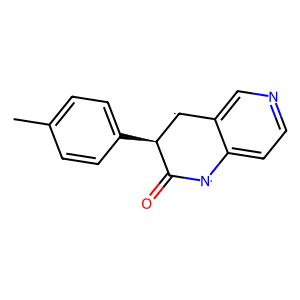

In [5]:
mol = Molecule(df['smiles'][0], input_type='smiles')
mol.visualize()

In [6]:
df = pd.read_csv("C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2_subset.csv")
print(f"Loaded {len(df)} molecules.")

Loaded 5000 molecules.


In [7]:
df.head(5)

,smiles,gap
0,O=C1[N]c2ccncc2[CH][C@@H]1c1ccc(cc1)C,3.047675
1,COc1cc(OC)ccc1/C=C/N(C(=O)C)C,4.410966
2,C=CCN(C(=O)C)/C=C/c1ccccc1C,4.639541
3,C=CCN(C(=O)C)/C=C/c1ccccc1F,4.492600
4,C=CCN(C(=O)C)/C=C/c1ccccc1Cl,4.612330


In [ ]:
valid_mol_objs = []
valid_gaps = []

for i, smi in enumerate(df['smiles']):
    try:
        mol = Molecule(smi, input_type='smiles')
        mol.hydrogens('add')
        mol.to_xyz(optimizer='MMFF', maxIters=200)
        # only add if 3D worked
        if mol.xyz is not None:
            valid_mol_objs.append(mol)
            valid_gaps.append(df['gap'][i])
        else:
            print(f"Skipped bc missing xyz: {smi}")
    except Exception as e:
        print(f"Failed on {smi} | Reason: {e}")

In [9]:
df_clean = pd.DataFrame({'smiles': [m.smiles for m in valid_mol_objs], 'gap': valid_gaps})
y = df_clean['gap'].values.reshape(-1, 1)
# compute descriptors
fp_featurizer = RDKitFingerprint(fingerprint_type='morgan', vector='bit', n_bits=1024, radius=3)
cm_featurizer = CoulombMatrix(cm_type='SC')
X_fp = fp_featurizer.represent(valid_mol_objs)
X_cm = cm_featurizer.represent(valid_mol_objs)
print("RDKit FP shape:", X_fp.shape)
print("Coulomb Matrix shape:", X_cm.shape)
print("Target shape:", y.shape)

featurizing molecules in batches of 203 ...
4895/4895 [==================================================] - 7s 2ms/step
Merging batch features ...    [DONE]
RDKit FP shape: (4895, 1024)
Coulomb Matrix shape: (4895, 1326)
Target shape: (4895, 1)


In [10]:
# make separate train/test splits for both scaled and unscaled targets
# 1. models that need scaled targets (MLP, KRR, GNN)
X_train_fp_scaled, X_test_fp_scaled, y_train_scaled, y_test_scaled = train_test_split(X_fp, y, test_size=0.2, random_state=42)
X_train_cm_scaled, X_test_cm_scaled, _, _ = train_test_split(X_cm, y, test_size=0.2, random_state=42)

xscaler_fp = StandardScaler()
xscaler_cm = StandardScaler()
yscaler = StandardScaler()

X_train_fp_scaled = xscaler_fp.fit_transform(X_train_fp_scaled)
X_test_fp_scaled = xscaler_fp.transform(X_test_fp_scaled)

X_train_cm_scaled = xscaler_cm.fit_transform(X_train_cm_scaled)
X_test_cm_scaled = xscaler_cm.transform(X_test_cm_scaled)

y_train_scaled = yscaler.fit_transform(y_train_scaled)
y_test_scaled = yscaler.transform(y_test_scaled)  

# 2. models that work with unscaled targets (Random Forest)
y_unscaled = df_clean['gap'].values
X_train_fp_unscaled, X_test_fp_unscaled, y_train_unscaled, y_test_unscaled = train_test_split(X_fp, y_unscaled, test_size=0.2, random_state=42)

tools.display_dataframe_to_user(name="Cleaned Feature Splits", dataframe=pd.DataFrame({"Split": ["X_train_fp_scaled", "X_test_fp_scaled", "X_train_cm_scaled", "X_test_cm_scaled", "y_train_scaled", "y_test_scaled", "X_train_fp_unscaled", "X_test_fp_unscaled", "y_train_unscaled", "y_test_unscaled"],
                                                                                       "Shape": [X_train_fp_scaled.shape, X_test_fp_scaled.shape, X_train_cm_scaled.shape, X_test_cm_scaled.shape, y_train_scaled.shape, y_test_scaled.shape,
                                                                                                 X_train_fp_unscaled.shape, X_test_fp_unscaled.shape, y_train_unscaled.shape, y_test_unscaled.shape]}))

Cleaned Feature Splits


## Kernel Ridge Regression baseline first

In [11]:
# Kernel Ridge on RDKit fingerprints 
krr = KernelRidge(kernel='rbf', alpha=1.0)
krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on scaled test set
y_pred_krr_scaled = krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform pred to compare w unscaled test target
y_pred_krr = yscaler.inverse_transform(y_pred_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval against true unscaled test target
print("Kernel Ridge (RDKit FP)")
metrics_krr = regression_metrics(y_test_krr, y_pred_krr)
print(metrics_krr[['MAE', 'RMSE', 'r_squared']])

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.518902  0.667565   0.726299


## Random Forest Regression baseline 

In [12]:
# Random Forest (RDKit FP) 
rfr = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=42)
rfr.fit(X_train_fp_unscaled, y_train_unscaled)
# predict
y_pred_rfr = rfr.predict(X_test_fp_unscaled)
# eval
print("Random Forest (RDKit FP)")
metrics_rfr = regression_metrics(y_test_unscaled, y_pred_rfr)
print(metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.426439  0.587233   0.788208


## Multi-Layer Perceptron with Morgan Fingerprints baseline 

In [ ]:
# MLP (Fingerprint)
mlp_fp = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[64, 128], activations=['ReLU', 'ReLU'],
             learning_rate=0.01, alpha=0.001, nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

mlp_fp.fit(X=X_train_fp_scaled, y=y_train_scaled)
y_pred_fp_scaled = mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
y_pred_fp = yscaler.inverse_transform(y_pred_fp_scaled)
y_test_fp = yscaler.inverse_transform(y_test_scaled)

## Multi-Layer Perceptron with Coulomb Matrix representation baseline 

In [ ]:
# MLP (Coulomb matrix)
mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[64, 128], activations=['ReLU', 'ReLU'],
             learning_rate=0.0001, alpha=0.001, nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

mlp_cm.fit(X=X_train_cm_scaled, y=y_train_scaled)
y_pred_cm_scaled = mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
y_pred_cm = yscaler.inverse_transform(y_pred_cm_scaled)
y_test_cm = yscaler.inverse_transform(y_test_scaled)

In [15]:
# eval
results = {"Kernel Ridge (RDKit FP)": regression_metrics(y_test_krr, y_pred_krr),
           "Random Forest (RDKit FP)": regression_metrics(y_test_unscaled, y_pred_rfr),
           "MLP (RDKit FP)": regression_metrics(y_test_fp, y_pred_fp),
           "MLP (Coulomb Matrix)": regression_metrics(y_test_cm, y_pred_cm)}

# display
print("Final Model Comparison")
for name, metrics_df in results.items():
    print(f"\n{name}")
    print(metrics_df[['MAE', 'RMSE', 'r_squared']])

Final Model Comparison

Kernel Ridge (RDKit FP)
        MAE      RMSE  r_squared
0  0.518902  0.667565   0.726299

Random Forest (RDKit FP)
        MAE      RMSE  r_squared
0  0.426439  0.587233   0.788208

MLP (RDKit FP)
        MAE      RMSE  r_squared
0  0.467539  0.608892   0.772297

MLP (Coulomb Matrix)
        MAE      RMSE  r_squared
0  0.662517  0.847184   0.559197


## Parity Plots and Residuals Histograms

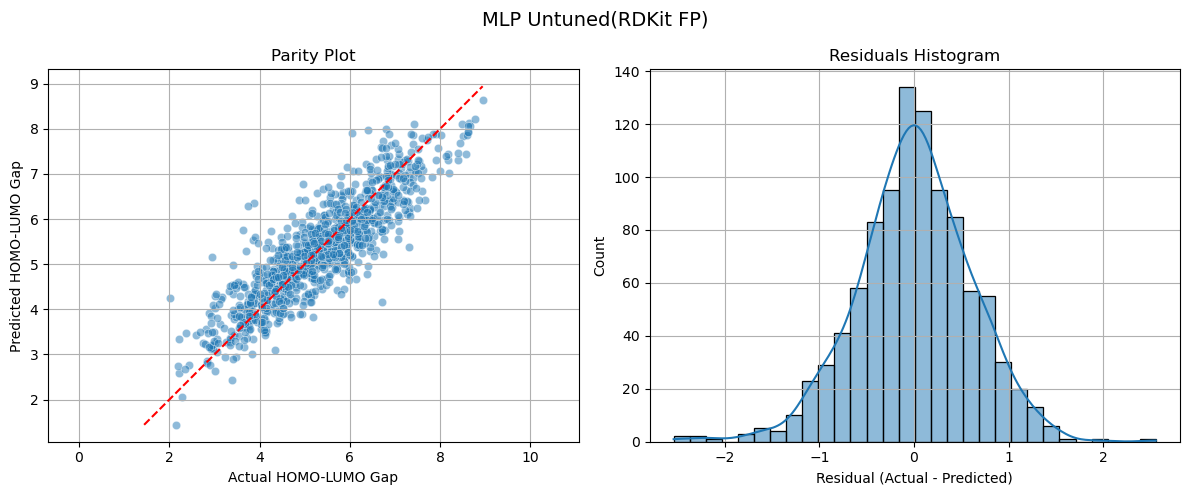

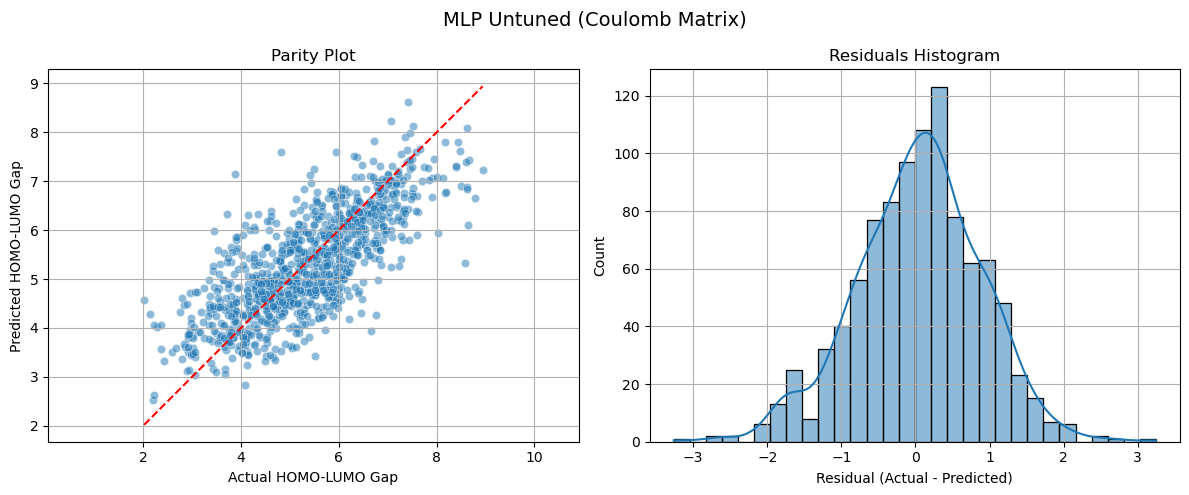

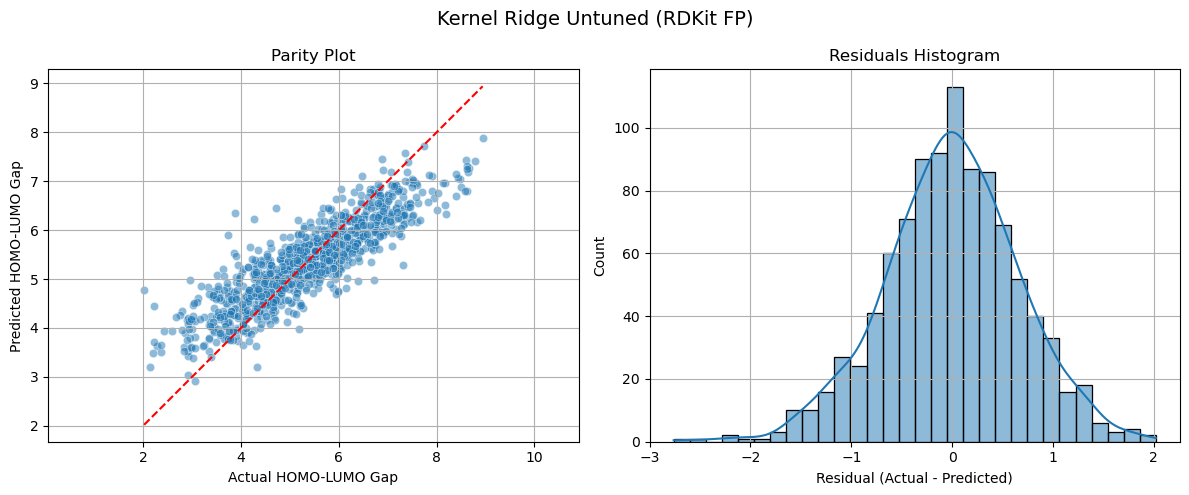

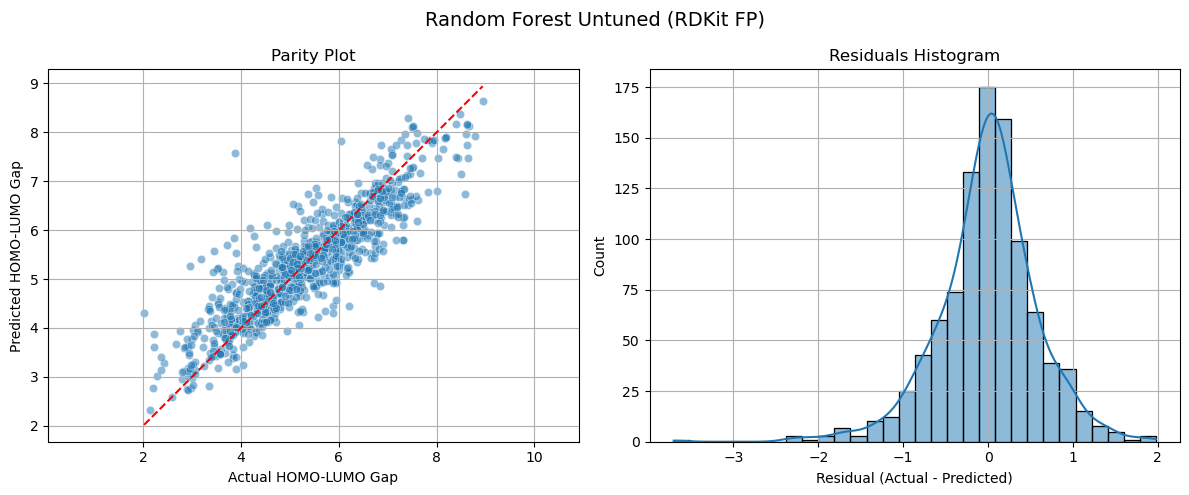

In [17]:
def plot_regression_results(y_true, y_pred, title="Model Evaluation", save_dir="plots"):
    residuals = y_true.flatten() - y_pred.flatten()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # parity plot
    sns.scatterplot(ax=axes[0], x=y_true.flatten(), y=y_pred.flatten(), alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], '--r')
    axes[0].set_xlabel("Actual HOMO-LUMO Gap")
    axes[0].set_ylabel("Predicted HOMO-LUMO Gap")
    axes[0].set_title("Parity Plot")
    axes[0].grid(True)
    axes[0].axis('equal')

    # residuals histogram
    sns.histplot(ax=axes[1], data=residuals, bins=30, kde=True)
    axes[1].set_title("Residuals Histogram")
    axes[1].set_xlabel("Residual (Actual - Predicted)")
    axes[1].grid(True)

    # overall title
    fig.suptitle(title, fontsize=14)

    # save fig as pdf for best overleaf upload format 
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"{title.lower().replace(' ', '_')}_plots.pdf")
    fig.savefig(filename, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

plot_regression_results(y_test_fp, y_pred_fp, title="MLP Untuned(RDKit FP)")
plot_regression_results(y_test_cm, y_pred_cm, title="MLP Untuned (Coulomb Matrix)")
plot_regression_results(y_test_krr, y_pred_krr, title="Kernel Ridge Untuned (RDKit FP)")
plot_regression_results(y_test_unscaled, y_pred_rfr, title="Random Forest Untuned (RDKit FP)")

## Tune hyperparameters for baseline models with Optuna 

In [ ]:
def objective_krr(trial):
    alpha = trial.suggest_float('alpha', 0.01, 0.5, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly'])
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True) if kernel == 'rbf' else None
    model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) if gamma else KernelRidge(alpha=alpha, kernel=kernel)
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_krr = optuna.create_study(direction='minimize')
study_krr.optimize(objective_krr, n_trials=100)

In [ ]:
def objective_rfr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300, step=50)
    max_depth = trial.suggest_int("max_depth", 10, 100, step=10)
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)
    model.fit(X_train_fp_unscaled, y_train_unscaled)
    preds = model.predict(X_test_fp_unscaled)
    metrics = regression_metrics(y_test_unscaled, preds)
    return metrics['MAE'][0]

study_rfr = optuna.create_study(direction='minimize')
study_rfr.optimize(objective_rfr, n_trials=100)

In [ ]:
def objective_mlp_fp(trial):
    lr = trial.suggest_float('lr', 1e-4, 2e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-4, 5e-2, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 128, 384, step=64)
    n2 = trial.suggest_int('n2', 128, 384, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)
    
    model.fit(X_train_fp_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_fp_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_fp = optuna.create_study(direction='minimize')
study_mlp_fp.optimize(objective_mlp_fp, n_trials=100)

In [ ]:
def objective_mlp_cm(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-6, 1e-1, log=True)
    act = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid', 'gelu'])
    n1 = trial.suggest_int('n1', 64, 256, step=64)
    n2 = trial.suggest_int('n2', 64, 256, step=64)

    model = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[n1, n2],
                activations=[act, act], learning_rate=lr, alpha=alpha,
                nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

    model.fit(X_train_cm_scaled, y_train_scaled)
    preds_scaled = model.predict(X_test_cm_scaled).reshape(-1, 1)
    preds = yscaler.inverse_transform(preds_scaled)
    y_test_inv = yscaler.inverse_transform(y_test_scaled)
    metrics = regression_metrics(y_test_inv, preds)
    return metrics['MAE'][0]

study_mlp_cm = optuna.create_study(direction='minimize')
study_mlp_cm.optimize(objective_mlp_cm, n_trials=100)

## Retrain Models with Best Parameters Found in Respective Optuna Studies

In [23]:
best_krr = study_krr.best_params

# build final model using best params
if best_krr['kernel'] == 'rbf':
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel='rbf', gamma=best_krr['gamma'])
else:
    final_krr = KernelRidge(alpha=best_krr['alpha'], kernel=best_krr['kernel'])

# train on scaled data
final_krr.fit(X_train_fp_scaled, y_train_scaled)
# predict on test set (scaled)
final_preds_krr_scaled = final_krr.predict(X_test_fp_scaled).reshape(-1, 1)
# inverse transform both predictions and gt
final_preds_krr = yscaler.inverse_transform(final_preds_krr_scaled)
y_test_krr = yscaler.inverse_transform(y_test_scaled)
# eval
final_metrics_krr = regression_metrics(y_test_krr, final_preds_krr)
print("Final Tuned Kernel Ridge (RDKit FP):")
print(final_metrics_krr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Kernel Ridge (RDKit FP):
        MAE      RMSE  r_squared
0  0.454045  0.592875   0.784119


In [24]:
# rebuild and retrain the RFR model
best_rfr = study_rfr.best_params
final_rfr = RandomForestRegressor(n_estimators=best_rfr['n_estimators'], max_depth=best_rfr['max_depth'], random_state=42)
final_rfr.fit(X_train_fp_unscaled, y_train_unscaled)

# predict on test set
final_preds_rfr = final_rfr.predict(X_test_fp_unscaled)

# eval using unscaled targets
final_metrics_rfr = regression_metrics(y_test_unscaled, final_preds_rfr)
print("Final Tuned Random Forest (RDKit FP):")
print(final_metrics_rfr[['MAE', 'RMSE', 'r_squared']])

Final Tuned Random Forest (RDKit FP):
        MAE      RMSE  r_squared
0  0.422968  0.582785   0.791404


In [ ]:
best_fp = study_mlp_fp.best_params
final_mlp_fp = MLP(engine='tensorflow', nfeatures=X_train_fp_scaled.shape[1], nneurons=[best_fp['n1'], best_fp['n2']], activations=[best_fp['activation'], best_fp['activation']], learning_rate=best_fp['lr'], alpha=best_fp['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# train on scaled data
final_mlp_fp.fit(X_train_fp_scaled, y_train_scaled)

# predict and inverse transform
final_preds_fp_scaled = final_mlp_fp.predict(X_test_fp_scaled).reshape(-1, 1)
final_preds_inv_fp = yscaler.inverse_transform(final_preds_fp_scaled)
y_test_inv_fp = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_fp = regression_metrics(y_test_inv_fp, final_preds_inv_fp)
print("Final Tuned MLP (RDKit FP):")
print(final_metrics_fp[['MAE', 'RMSE', 'r_squared']])

In [ ]:
best_cm = study_mlp_cm.best_params
final_mlp_cm = MLP(engine='tensorflow', nfeatures=X_train_cm_scaled.shape[1], nneurons=[best_cm['n1'], best_cm['n2']], activations=[best_cm['activation'], best_cm['activation']], learning_rate=best_cm['lr'], alpha=best_cm['alpha'], nepochs=100, batch_size=64, loss='mean_squared_error', is_regression=True)

# train on scaled data
final_mlp_cm.fit(X_train_cm_scaled, y_train_scaled)

# predict and inverse transform
final_preds_cm_scaled = final_mlp_cm.predict(X_test_cm_scaled).reshape(-1, 1)
final_preds_inv_cm = yscaler.inverse_transform(final_preds_cm_scaled)
y_test_inv_cm = yscaler.inverse_transform(y_test_scaled)

# eval in eV
final_metrics_cm = regression_metrics(y_test_inv_cm, final_preds_inv_cm)
print("Final Tuned MLP (Coulomb Matrix):")
print(final_metrics_cm[['MAE', 'RMSE', 'r_squared']])

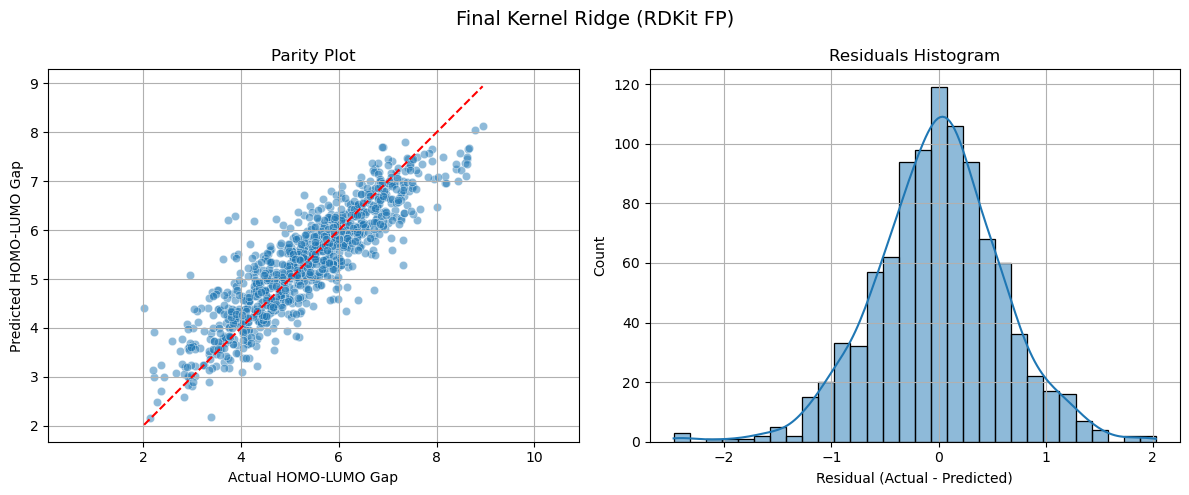

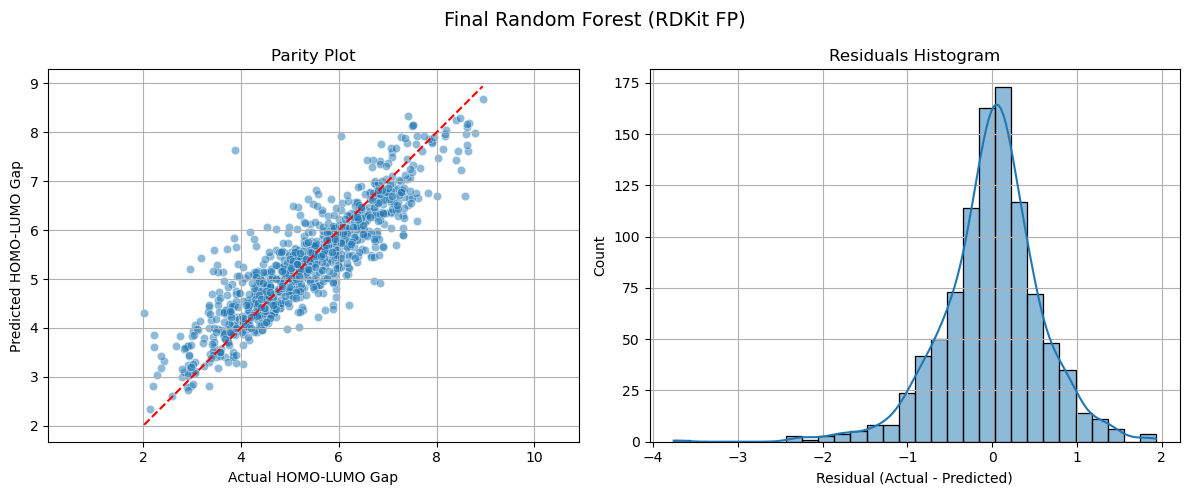

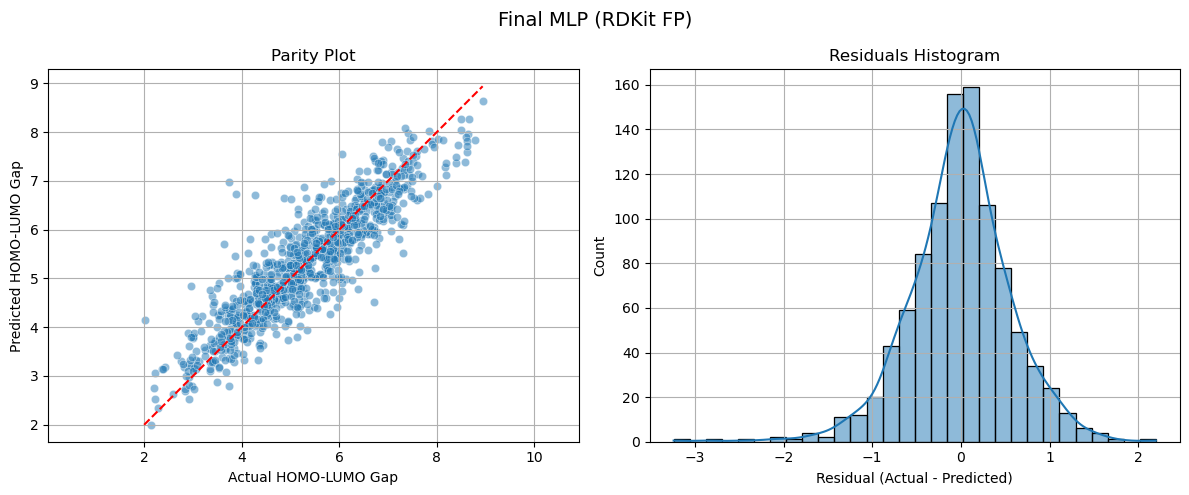

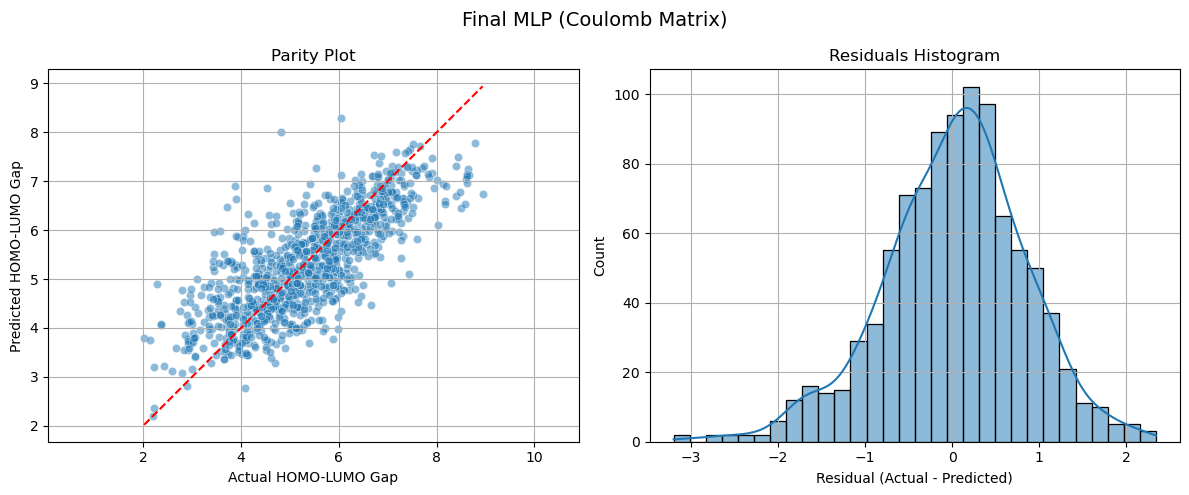

In [ ]:
plot_regression_results(y_test_krr, final_preds_krr, title="Final Kernel Ridge (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_unscaled, final_preds_rfr, title="Final Random Forest (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_fp, final_preds_inv_fp, title="Final MLP (RDKit FP)", save_dir="plots")
plot_regression_results(y_test_inv_cm, final_preds_inv_cm, title="Final MLP (Coulomb Matrix)", save_dir="plots")


| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| MLP (Tuned)          | RDKit Fingerprints   | 0.426 | 0.574 | 0.798 | Strong performance across all metrics   |
| KRR (Tuned)          | RDKit Fingerprints   | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R² than MLP|
| RF (Tuned)           | RDKit Fingerprints   | 0.423| 0.583 | 0.791  | Top MAE, but slightly higher R²/RMSE    |
| MLP (Tuned)          | Coulomb Matrix       | 0.636 | 0.819 | 0.588 | Significantly worse than FP models      |
| MLP (Untuned Baseline) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Reasonable baseline performance         |
| KRR (Untuned Baseline) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Noticeable drop from tuned KRR          |
| RF (Untuned Baseline) | RDKit Fingerprints  | 0.426| 0.587 | 0.788  | Surprisingly strong untuned performance |
| MLP (Untuned Baseline) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Confirms Coulomb Matrix as weak         |

Save best model and metrics

In [ ]:
# create a save directory
os.makedirs("saved_models", exist_ok=True)

# save the final trained MLP model (Keras backend)
final_mlp_fp.model.save("saved_models/best_mlp_fp_model_keras")

# save the X and Y scalers
joblib.dump(xscaler_fp, "saved_models/xscaler_fp.pkl")
joblib.dump(yscaler, "saved_models/yscaler.pkl")

# save evaluation metrics
final_metrics_fp.to_csv("saved_models/best_mlp_fp_metrics.csv", index=False)

If you wanted to reload these later...

In [29]:
# from tensorflow.keras.models import load_model

# # load model and scalersand metrics
# mlp_model = load_model("saved_models/best_mlp_fp_model_keras")
# xscaler_fp = joblib.load("saved_models/xscaler_fp.pkl")
# yscaler = joblib.load("saved_models/yscaler.pkl")
# metrics_df = pd.read_csv("saved_models/best_mlp_fp_metrics.csv")

# Training a Baseline GNN with ChemML
ChemML's `tensorise_molecules` generates its own graph. Its important to note this graph is not the official graph from PCQM4Mv2. It may miss out on features OGB uses like formal charge, aromatacity flags, atomic chirality, and explicit hydrogens. However, tensorise_molecules is a good choice for quick prototyping and it handles graph generation and tensor formatting in a numpy-friendly way which was easier for me to understand. Final training will use smiles2graph for compatability with OGB splits and better feature representation. 

In [ ]:
# tensorize molecules
X_atoms, X_bonds, X_edges = tensorise_molecules(valid_mol_objs)
y = df_clean['gap'].values.reshape(-1, 1)

# train test split (80/20)
split = int(0.8 * len(y))
X_atoms_train, X_atoms_test = X_atoms[:split], X_atoms[split:]
X_bonds_train, X_bonds_test = X_bonds[:split], X_bonds[split:]
X_edges_train, X_edges_test = X_edges[:split], X_edges[split:]
y_train, y_test = y[:split], y[split:]

# scale target
yscaler = StandardScaler()
y_train_scaled = yscaler.fit_transform(y_train)

# model input shapes
max_atoms = X_atoms.shape[1]
max_degree = X_bonds.shape[2]
num_atom_features = X_atoms.shape[-1]
num_bond_features = X_bonds.shape[-1]

# input layers
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

# GNN layers
conv1 = NeuralGraphHidden(8, activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(8, activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(128, activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(128, activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(128, activation='relu')([conv2, bonds_input, edges_input])

# fingerprint aggregation
fingerprint = Add()([fp1, fp2, fp3])

# dense layers
dense1 = Dense(128, activation='relu')(fingerprint)
dense2 = Dense(64, activation='relu')(dense1)
output = Dense(1, activation='linear')(dense2)

# model compilation
model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# model training
model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=1, validation_split=0.1)

# preds and eval
y_pred = model.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred = yscaler.inverse_transform(y_pred)
metrics = regression_metrics(y_test, y_pred)
print("\nGNN Model Results:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

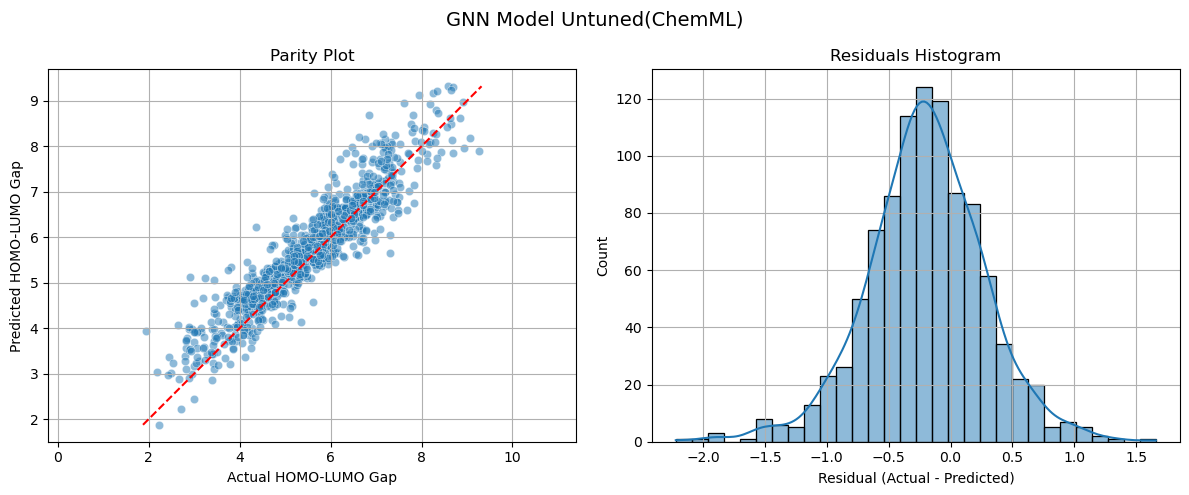

In [19]:
# plot results
plot_regression_results(y_test, y_pred, title="GNN Model Untuned(ChemML)", save_dir="plots")

In [ ]:
from tensorflow.keras.metrics import MeanAbsoluteError

def objective_gnn(trial):
    conv_width = trial.suggest_categorical('conv_width', [8, 16, 32])
    fp_length = trial.suggest_categorical('fp_length', [96, 128, 160])
    n1 = trial.suggest_int('n1', 128, 192, step=32)
    n2 = trial.suggest_int('n2', 64, 96, step=32)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    alpha = trial.suggest_float('alpha', 1e-8, 1e-4, log=True)
    activation = 'relu'

    # model definition
    atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
    bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
    edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

    conv1 = NeuralGraphHidden(conv_width, activation=activation)([atoms_input, bonds_input, edges_input])
    conv2 = NeuralGraphHidden(conv_width, activation=activation)([conv1, bonds_input, edges_input])

    fp1 = NeuralGraphOutput(fp_length, activation=activation)([atoms_input, bonds_input, edges_input])
    fp2 = NeuralGraphOutput(fp_length, activation=activation)([conv1, bonds_input, edges_input])
    fp3 = NeuralGraphOutput(fp_length, activation=activation)([conv2, bonds_input, edges_input])
    fingerprint = Add()([fp1, fp2, fp3])

    dense1 = Dense(n1, activation=activation, kernel_regularizer=regularizers.l2(alpha))(fingerprint)
    dense2 = Dense(n2, activation=activation, kernel_regularizer=regularizers.l2(alpha))(dense1)
    output = Dense(1, activation='linear')(dense2)

    model = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

    history = model.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=100, batch_size=64, verbose=0, validation_split=0.2)

    # return best validation MAE
    val_mae = min(history.history["val_mean_absolute_error"])  
    return val_mae

study_gnn = optuna.create_study(direction='minimize')  
study_gnn.optimize(objective_gnn, n_trials=50)

## Retraining ChemML GNN with Best Parameter Found in Optuna Search

In [ ]:
params = study_gnn.best_params

# redefine and compile using best params
atoms_input = Input(shape=(max_atoms, num_atom_features), name="atom_inputs")
bonds_input = Input(shape=(max_atoms, max_degree, num_bond_features), name="bond_inputs")
edges_input = Input(shape=(max_atoms, max_degree), name="edge_inputs", dtype="int32")

conv1 = NeuralGraphHidden(params['conv_width'], activation='relu')([atoms_input, bonds_input, edges_input])
conv2 = NeuralGraphHidden(params['conv_width'], activation='relu')([conv1, bonds_input, edges_input])

fp1 = NeuralGraphOutput(params['fp_length'], activation='relu')([atoms_input, bonds_input, edges_input])
fp2 = NeuralGraphOutput(params['fp_length'],activation='relu')([conv1, bonds_input, edges_input])
fp3 = NeuralGraphOutput(params['fp_length'], activation='relu')([conv2, bonds_input, edges_input])
fingerprint = Add()([fp1, fp2, fp3])

dense1 = Dense(params['n1'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(fingerprint)
dense2 = Dense(params['n2'], activation='relu', kernel_regularizer=regularizers.l2(params['alpha']))(dense1)
output = Dense(1, activation='linear')(dense2)

final_gnn = Model(inputs=[atoms_input, bonds_input, edges_input], outputs=output)
final_gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['lr']), loss='mean_squared_error')

final_gnn.fit([X_atoms_train, X_bonds_train, X_edges_train], y_train_scaled, epochs=200, batch_size=64, verbose=1)

# final eval
y_pred_final = final_gnn.predict([X_atoms_test, X_bonds_test, X_edges_test])
y_pred_final = yscaler.inverse_transform(y_pred_final)
final_metrics = regression_metrics(y_test, y_pred_final)
print("\nFinal Tuned GNN Results:")
print(final_metrics[['MAE', 'RMSE', 'r_squared']])

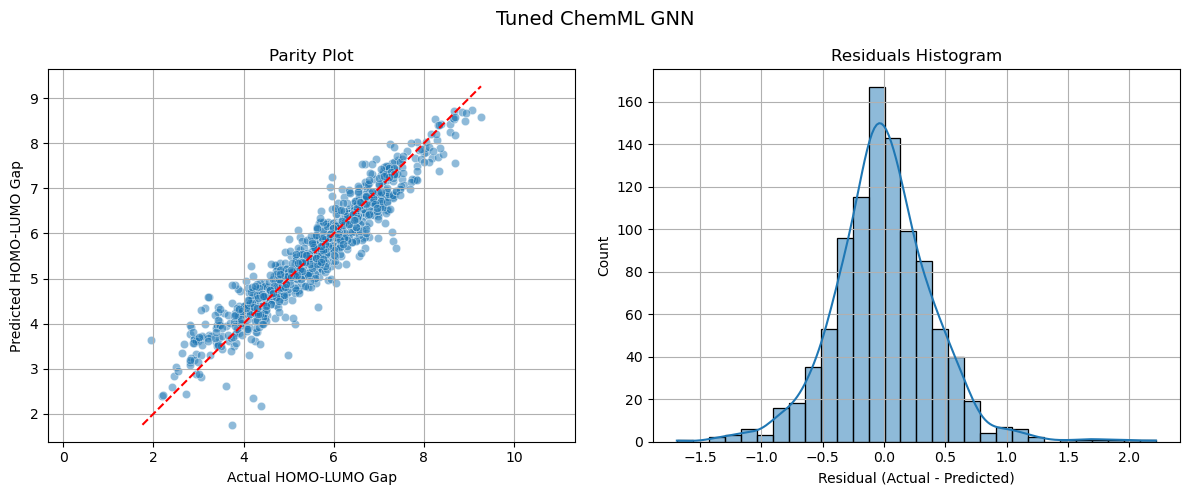

In [22]:
plot_regression_results(y_test, y_pred_final, title="Tuned ChemML GNN", save_dir="plots")

In [55]:
import json

# make a directory for this specific model
save_dir = "saved_models/gnn_tensorise_molecules_model"
os.makedirs(save_dir, exist_ok=True)

# 1. save the trained GNN model
final_gnn.save(os.path.join(save_dir, "gnn_tensorise_molecules_model_tf"), save_format="tf")

# 2. save the y target scaler
with open(os.path.join(save_dir, "gnn_tensorise_molecules_target_scaler.pkl"), "wb") as f:
    pickle.dump(yscaler, f)

# 3. save the final metrics
final_metrics.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_metrics.csv"), index=False)

# 4. save predictions
pred_df = pd.DataFrame({"true_gap": y_test.flatten(), "predicted_gap": y_pred_final.flatten()})
pred_df.to_csv(os.path.join(save_dir, "gnn_tensorise_molecules_predictions.csv"), index=False)

# 5. save the best hyperparameters
with open(os.path.join(save_dir, "gnn_tensorise_molecules_best_params.json"), "w") as f:
    json.dump(params, f, indent=4)

INFO:tensorflow:Assets written to: saved_models/gnn_tensorise_molecules_model\gnn_tensorise_molecules_model_tf\assets


## ChemML GNN Model Results
| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| GNN (Tuned)            | tensorise_molecules Graph   | 0.302 | 0.411 | 0.900 | Best performance across all metrics   |
| GNN (Untuned)          | tensorise_molecules Graph   | 0.400 | 0.519 | 0.841 | Good overall|


---
# Final Model Training

Having explored different molecular graph representations and model architectures, I am now moving to training what is expected to be the best-performing model using the full dataset. The earlier GNN model was based on `tensorise_molecules` (ChemML) graphs and had strong performance with a **mean absolute error (MAE) around 0.30**. These graphs are based on RDKit's internal descriptors and do not reflect the original PCQM4Mv2 graph structure used in the Open Graph Benchmark (OGB). Therefore, I will shift focus to the `smiles2graph` representation provided by OGB, which aligns more directly with the benchmark's evaluation setup and top-performing models on the leaderboard.


| Source                         | Atom/Bond Features                                                 | Format                                          | Customizable?     | Alignment with PCQM4Mv2?  |
| ------------------------------ | ------------------------------------------------------------------ | ----------------------------------------------- | ----------------- | ---------------------- |
| `tensorise_molecules` (ChemML) | RDKit-based descriptors (ex: atom number, degree, hybridization) | NumPy tensors (`X_atoms`, `X_bonds`, `X_edges`) | Limited           |  Not aligned          |
| `smiles2graph` (OGB / PyG)     | Predefined categorical features from PCQM4Mv2                      | PyTorch Geometric `Data` objects                |  Highly flexible |  Matches OGB standard |

By using `smiles2graph`, we:

* Use OGB-standard graph construction and feature encoding for fair comparisons with leaderboard models
* Include learnable AtomEncoder and BondEncoder embeddings from `ogb.graphproppred.mol_encoder`, which improve model expressiveness
* Maintain compatibility with PyTorch Geometric, DGL, and OGB tools

I will also concatenate GNN-derived embeddings with SMILES-based RDKit descriptors, feeding this hybrid representation into MLP head. This allows you to combine structural and cheminformatics perspectives for improved prediction accuracy. With this setup, I aim to improve upon the MAE of \~0.30 achieved earlier and push closer toward state-of-the-art performance.


## Step 1: Load PyG-Compatible Dataset



In [ ]:
def check_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available? ", torch.cuda.is_available())
    
    if torch.cuda.is_available():
        print("Device count:", torch.cuda.device_count())
        print("GPU Name:", torch.cuda.get_device_name(0))
        print("Current device:", torch.cuda.current_device())
    else:
        print("Running on CPU")

check_cuda()

PyTorch version: 2.4.1+cu118
CUDA available?  True
Device count: 1
GPU Name: NVIDIA GeForce RTX 3070 Ti
Current device: 0


In [ ]:
# 1. load OGB dataset 
dataset = PygPCQM4Mv2Dataset(root='C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2_Pytorch_Geometric', smiles2graph=smiles2graph)
split_idx = dataset.get_idx_split()

#  Step 2: Extract SMILES from Original Dataset

In [58]:
# 2. load SMILES dataset
smiles_dataset = PCQM4Mv2Dataset(root='C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2', only_smiles=True)

# extract SMILES from records
num_mols = len(smiles_dataset)
print(num_mols)
smiles_list = [smiles_dataset[i][0] for i in range(num_mols)] # each record is (smiles, gap)

3746620


In [ ]:
# 3. extract SMILES compute RDKit descriptors 
def compute_rdkit_features(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return [Descriptors.MolWt(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.RingCount(mol)]

rdkit_features = np.array([compute_rdkit_features(smi) for smi in smiles_list])

# Step 4: attach RDKit features to PyG data objects

In [ ]:
# 4. convert to tensor
rdkit_tensor = torch.tensor(rdkit_features, dtype=torch.float32)
# attach globally
dataset.data.rdkit_feats = rdkit_tensor
# register correct slices (like it does during preprocessing)
dataset.slices['rdkit_feats'] = torch.arange(0, rdkit_tensor.size(0) + 1, step=1)
# patch how it concatenates this custom feature during batching
dataset.data.__cat_dim__ = lambda key, value, *_: 0 if key == "rdkit_feats" else Data.__cat_dim__(dataset.data, key, value)

In [61]:
print(hasattr(dataset[0], 'rdkit_feats')) # True
print(dataset[0].rdkit_feats.shape) # torch.Size([6])

True
torch.Size([1, 6])


## Step 5: Define the Hybrid GNN Model

The final architecture uses both structural and cheminformatics data by combining GNN-learned graph embeddings with SMILES-derived RDKit descriptors. This Hybrid GNN model uses `smiles2graph` for graph construction and augments it with RDKit-based molecular features for improved prediction accuracy.

### Model Components:

* **AtomEncoder / BondEncoder**
  Transforms categorical atom and bond features (provided by OGB) into learnable embeddings using the encoders from `ogb.graphproppred.mol_encoder`. These provide a strong foundation for expressive graph learning.

* **GINEConv Layers (x2)**
  I use two stacked GINEConv layers (Graph Isomorphism Network with Edge features). These layers perform neighborhood aggregation based on edge attributes, allowing the model to capture localized chemical environments.

* **Global Mean Pooling**
  After message passing, node level embeddings are aggregated into a fixed size graph level representation using `global_mean_pool`.

* **Concatenation with RDKit Descriptors**
  The pooled GNN embedding is concatenated with external RDKit descriptors, which capture global molecular properties not easily inferred from graph data alone.

* **MLP Prediction Head**
  A multilayer perceptron processes the combined feature vector with ReLU activations, dropout regularization, and linear layers to predict the HOMO–LUMO gap.

In [62]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2):
        super().__init__()
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), ReLU(), Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim, hidden_dim // 2), ReLU(), 
                              Dropout(dropout_rate),
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        # encode atoms and bonds
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        # GNN convolutions
        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        # handle RDKit features
        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            if x.shape[0] != rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape}) vs rdkit_feats ({rdkit_feats.shape})")
            x = torch.cat([x, rdkit_feats], dim=1)
        else:
            # raise an error or warn
            raise ValueError("RDKit features not found in the data object")

        return self.mlp(x)

# Step 6: train/val/test split 

In [63]:
train_dataset = Subset(dataset, split_idx['train'])
valid_dataset = Subset(dataset, split_idx['valid'])
test_dataset = Subset(dataset, split_idx['test-dev'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)

# Step 7: training loop 

In [ ]:
# initialize model
model = HybridGNN(gnn_dim=128, rdkit_dim=rdkit_features.shape[1], hidden_dim=256)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
best_val_loss = float('inf')
patience = 10
patience_counter = 0

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    loss = F.mse_loss(preds, targets)
    return loss.item(), preds, targets

# training loop
for epoch in range(1, 101): # long since early stopping
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch:02d}"):
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_dir = "saved_models/gnn_smiles2graph_model"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "hybridgnn_untuned.pt"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# final eval on val set
model.load_state_dict(torch.load(os.path.join(save_dir, "hybridgnn_untuned.pt")))
model.eval()
_, final_preds, final_targets = evaluate(model, valid_loader)
metrics = regression_metrics(final_targets.numpy(), final_preds.numpy())
print("\nGNN Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])

# Step 8: Optuna tuning of Hybrid GNN

In [66]:
class HybridGNN(Module):
    def __init__(self, gnn_dim, rdkit_dim, hidden_dim, dropout_rate=0.2, activation='ReLU'):
        super().__init__()
        act_map = {'ReLU': torch.nn.ReLU(), 'ELU': torch.nn.ELU(), 'GELU': torch.nn.GELU(), 'LeakyReLU': torch.nn.LeakyReLU(), 'PReLU': torch.nn.PReLU(), 'Swish': torch.nn.SiLU()}
        act_fn = act_map[activation]
        self.gnn_dim = gnn_dim
        self.rdkit_dim = rdkit_dim

        self.atom_encoder = AtomEncoder(emb_dim=gnn_dim)
        self.bond_encoder = BondEncoder(emb_dim=gnn_dim)

        self.conv1 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.conv2 = GINEConv(Sequential(Linear(gnn_dim, gnn_dim), act_fn, Linear(gnn_dim, gnn_dim)))
        self.pool = global_mean_pool

        self.mlp = Sequential(Linear(gnn_dim + rdkit_dim, hidden_dim), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim, hidden_dim // 2), act_fn, 
                              Dropout(dropout_rate), 
                              Linear(hidden_dim // 2, 1))

    def forward(self, data):
        x = self.atom_encoder(data.x)
        edge_attr = self.bond_encoder(data.edge_attr)

        x = self.conv1(x, data.edge_index, edge_attr)
        x = self.conv2(x, data.edge_index, edge_attr)
        x = self.pool(x, data.batch)

        rdkit_feats = getattr(data, 'rdkit_feats', None)
        if rdkit_feats is not None:
            if x.shape[0] != rdkit_feats.shape[0]:
                raise ValueError(f"Shape mismatch: GNN output ({x.shape}) vs rdkit_feats ({rdkit_feats.shape})")
            x = torch.cat([x, rdkit_feats], dim=1)
        else:
            raise ValueError("RDKit features not found in the data object.")

        return self.mlp(x)

Multiple rounds of tuning have suggested to refine my search space to ReLU, GELU, and Swish activation functions and Adam and AdamW optimizers. Therefore, I have commented out unused parameters like momentum for SGD and the unused optimizers. 

In [ ]:
def objective(trial):
    # hyperparameter search space 
    gnn_dim = trial.suggest_categorical("gnn_dim", [384, 512, 1024])
    hidden_dim = trial.suggest_categorical("hidden_dim", [256, 384, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.4)
    lr = trial.suggest_float("lr", 8e-6, 1e-3, log=True)
    activation = trial.suggest_categorical("activation", ['ReLU', 'GELU', 'Swish'])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW"])
    # momentum = trial.suggest_float("momentum", 0.8, 0.99, log=True) if optimizer_name == "SGD" else None
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-4, log=True)

    # data loading uses a tiny subset for faster tuning (if more time was allotted, full dataset should be used)
    tiny_subset_size = 150016
    np.random.seed(42)
    idx_subset = np.random.choice(len(split_idx['train']), tiny_subset_size, replace=False)
    train_subset = Subset(dataset, idx_subset)
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valid_loader = DataLoader(Subset(dataset, split_idx['valid']), batch_size=64)

    # model instantiation (same as before) 
    model = HybridGNN(gnn_dim=gnn_dim, rdkit_dim=rdkit_features.shape[1], hidden_dim=hidden_dim, dropout_rate=dropout_rate, activation=activation)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # optimizer instantiation (same as before) 
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    # elif optimizer_name == "SGD":
    #     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # elif optimizer_name == "RMSprop":
    #     optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(f"Optimizer '{optimizer_name}' not supported")

    # training loop with NaN check 
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(1, 100): 
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))

            # check for NaN loss 
            if torch.isnan(loss).any():
                print(f"Trial {trial.number} | Epoch {epoch:02d} | NaN loss detected so pruning trial")
                trial.report(float('inf'), epoch) # report v high loss
                raise optuna.TrialPruned()

            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader.dataset)

        # validation (same as before) 
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                batch = batch.to(device)
                pred = model(batch)
                val_loss += F.mse_loss(pred, batch.y.view(-1, 1)).item() * batch.num_graphs
        val_loss /= len(valid_loader.dataset)

        # logging, reporting, pruning, early stopping 
        print(f"Trial {trial.number} | Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Optimizer: {optimizer_name}")
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Trial {trial.number} - Early stopping triggered at epoch {epoch}")
                break

    return best_val_loss

if __name__ == '__main__':
    study_name = "final_2d_gnn_study"
    storage_name = f"sqlite:///{study_name}.db"
    study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", pruner=optuna.pruners.MedianPruner())

    def save_study_callback(study, trial):
        pass # saving to the db is handled by the storage parameter

    study.optimize(objective, n_trials=100, callbacks=[save_study_callback])
    print(study.best_params)
    # save the study as a pickle file if you want a snapshot
    joblib.dump(study, f"{study_name}_final.pkl")
    
    # final plots 
    fig = vis.plot_optimization_history(study)
    fig.show()
    fig_params = vis.plot_param_importances(study)
    fig_params.show()
    fig_intermediate = vis.plot_intermediate_values(study)
    fig_intermediate.show()
    fig_parallel_coordinate = vis.plot_parallel_coordinate(study)
    fig_parallel_coordinate.show()
    fig_slice = vis.plot_slice(study)
    fig_slice.show()

In [ ]:
print(study.best_params)

{'gnn_dim': 512, 'hidden_dim': 256, 'dropout_rate': 0.2914244608772888, 'lr': 0.00017488102215418725, 'activation': 'Swish', 'optimizer': 'AdamW', 'weight_decay': 2.2456714056135235e-05}


# Step 9: Retrain with best prameters

In [ ]:
# best params from Optuna
best_params = study.best_params

# reload full training data 
train_dataset = Subset(dataset, split_idx['train'])
valid_dataset = Subset(dataset, split_idx['valid'])
test_dataset = Subset(dataset, split_idx['test-dev'])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# reinitialize model 
model = HybridGNN(gnn_dim=best_params['gnn_dim'],
                  rdkit_dim=rdkit_features.shape[1],
                  hidden_dim=best_params['hidden_dim'],
                  dropout_rate=best_params['dropout_rate'],
                  activation=best_params['activation'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# instantiate Optimizer based on Optuna's choice
optimizer_name = best_params['optimizer']
num_epochs = 100
num_warmup_steps = int(0.1 * num_epochs * len(train_loader))  # 10% warm-up
total_steps = num_epochs * len(train_loader)
lr = best_params['lr']
weight_decay = best_params['weight_decay']

if optimizer_name == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
elif optimizer_name == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    raise ValueError(f"Optimizer '{optimizer_name}' not supported.")

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# early stopping training loop w loss tracking and plotting 
best_val_loss = float('inf')
patience = 10
patience_counter = 0
train_losses = []
val_losses = []

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

for epoch in range(1, num_epochs):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        pred = model(batch)
        loss = F.mse_loss(pred, batch.y.view(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * batch.num_graphs

    train_loss = total_loss / len(train_loader.dataset)
    val_loss, val_preds, val_targets = evaluate(model, valid_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_hybridgnn.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

# load best model and eval
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()
# use the val set for final evaluation
final_val_loss, val_preds, val_targets = evaluate(model, valid_loader)
metrics = regression_metrics(val_targets.numpy(), val_preds.numpy())
print("\nFinal Validation Set Evaluation:")
print(metrics[['MAE', 'RMSE', 'r_squared']])
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Step 10: Evaluate Model Performance

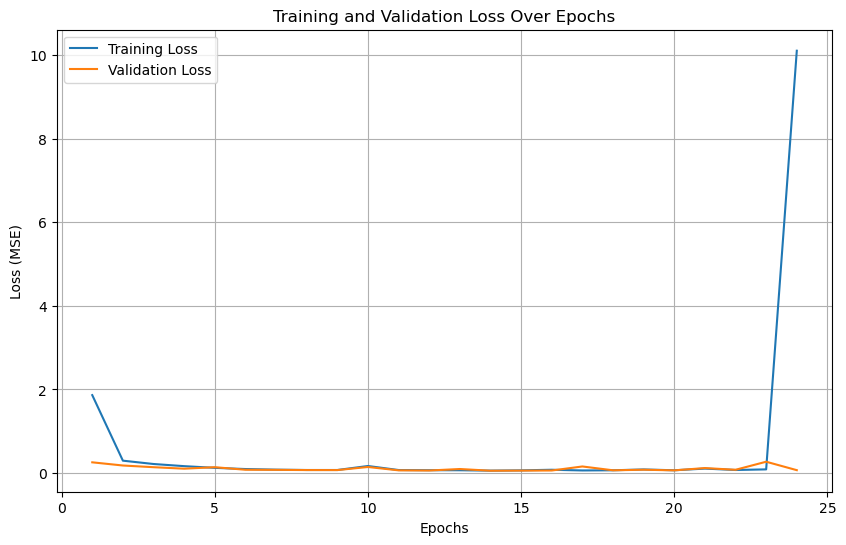

In [70]:
# plotting training and validation loss 
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

| Model Type             | Featurization        |   MAE |  RMSE |   R² | Notes             |
|------------------------|----------------------|-------|-------|------|-------------------|
| Hybrid GNN (Tuned)| OGB smiles2graph + RDKit descriptors | 0.159 | 0.234 | 0.965 | Best   |
| Hybrid GNN (Untuned) | OGB smiles2graph + RDKit descriptors | 0.223 | 0.308 | 0.939 | 2nd best|

c:\Users\mattg\anaconda3\envs\chemml_env\lib\site-packages\ogb\lsc\pcqm4mv2.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  split_dict = torch.load(osp.join(self.folde

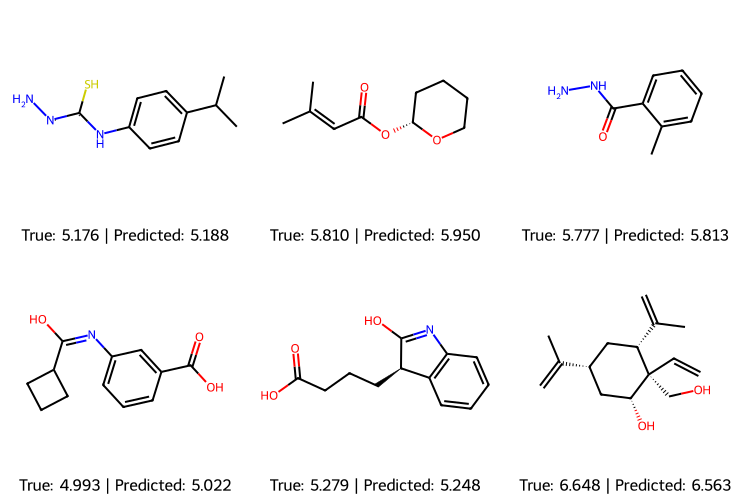

In [ ]:
import random
from rdkit.Chem import Draw

# load SMILES w labels (validation set only)
smiles_dataset = PCQM4Mv2Dataset(root='C:/Users/mattg/Downloads/HOMO-LUMO/data/pcqm4mv2', only_smiles=True)
split_idx = smiles_dataset.get_idx_split()
valid_idx = split_idx['valid']

# load true labels and SMILES for validation set 
valid_smiles = [smiles_dataset[i] for i in valid_idx]  # (smiles, label) tuples

# model predictions (aligned with validation set) 
model.load_state_dict(torch.load("best_hybridgnn.pt"))
model.eval()

# reload validation set DataLoader
valid_dataset = Subset(dataset, split_idx['valid'])
valid_loader = DataLoader(valid_dataset, batch_size=64)

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            loss = F.mse_loss(pred, batch.y.view(-1, 1))
            total_loss += loss.item() * batch.num_graphs
            preds.append(pred.cpu())
            targets.append(batch.y.view(-1, 1).cpu())
    avg_loss = total_loss / len(loader.dataset)
    preds = torch.cat(preds)
    targets = torch.cat(targets)
    return avg_loss, preds, targets

# rerun evaluation to recover val_preds
final_val_loss, val_preds, val_targets = evaluate(model, valid_loader)
val_preds = val_preds.numpy().flatten()

# 6 random indices from validation set 
r_idx = random.sample(range(len(valid_smiles)), 6)

# extract data 
Smiles = [valid_smiles[r][0] for r in r_idx]
GT = [valid_smiles[r][1] for r in r_idx]
Mols = [Chem.MolFromSmiles(smi) for smi in Smiles]
Pred = [val_preds[r] for r in r_idx]

# format labels 
labelList = [f"True: {gt:.3f} | Predicted: {pred:.3f}" for gt, pred in zip(GT, Pred)]

# display molecules with RDKit
img = Draw.MolsToGridImage(Mols, molsPerRow=3, subImgSize=(250, 250), legends=labelList, useSVG=True)
img

Copy-paste these into the app:
C/N=C(\N(c1ccc(c(c1)Cl)Cl)O)/O, CO/C=C(/C(=O)OC)\Oc1ccccc1C, N#C[C@@H](c1ccccn1)C(=O)OC, CC[C@H](CC[C@H](CC)O)O, Fc1ccc(cc1)C(=O)Nc1cccc(c1)O, CN1C[C@@H]2C[C@H](C1)[C@@H]1[N@](C2)CCCC1


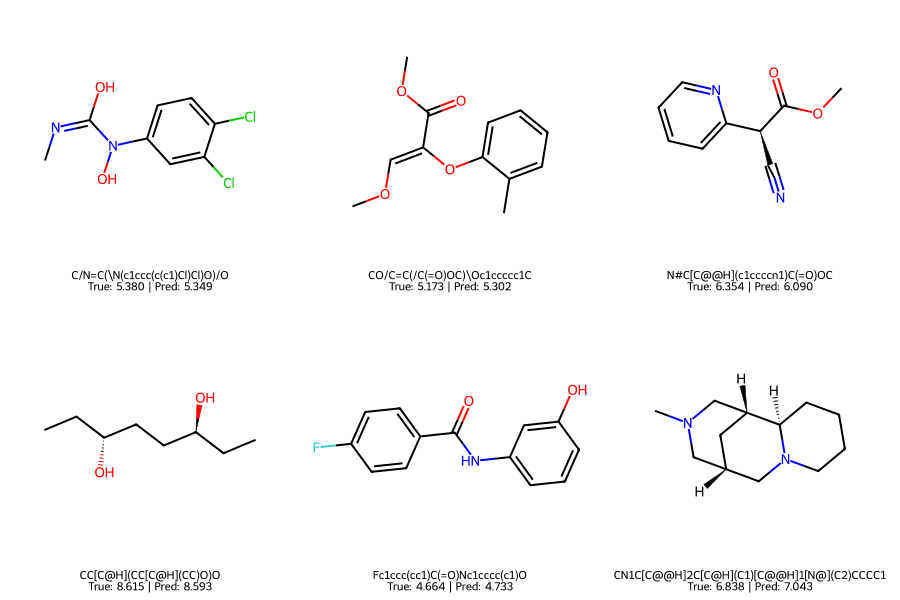

,SMILES,Ground Truth (eV),Predicted (eV)
0,C/N=C(\N(c1ccc(c(c1)Cl)Cl)O)/O,5.3797,5.3491
1,CO/C=C(/C(=O)OC)\Oc1ccccc1C,5.1729,5.3016
2,N#C[C@@H](c1ccccn1)C(=O)OC,6.3539,6.0903
3,CC[C@H](CC[C@H](CC)O)O,8.6151,8.5926
4,Fc1ccc(cc1)C(=O)Nc1cccc(c1)O,4.6640,4.7329
5,CN1C[C@@H]2C[C@H](C1)[C@@H]1[N@](C2)CCCC1,6.8382,7.0431


In [ ]:
# 6 random indices from validation set
r_idx = random.sample(range(len(valid_smiles)), 6)

# extract data
Smiles = [valid_smiles[r][0] for r in r_idx]
GT = [valid_smiles[r][1] for r in r_idx]
Mols = [Chem.MolFromSmiles(smi) for smi in Smiles]
Pred = [val_preds[r] for r in r_idx]

# print SMILES to paste into Streamlit for test
print("Copy-paste these into the app:")
print(", ".join(Smiles))

# format labels
labelList = [f"{smi}\nTrue: {gt:.3f} | Pred: {pred:.3f}"
             for smi, gt, pred in zip(Smiles, GT, Pred)]

# display molecules
img = Draw.MolsToGridImage(Mols, molsPerRow=3, subImgSize=(300, 300), legends=labelList, useSVG=True)
display(img)  

# output as df if for saving 
summary_df = pd.DataFrame({"SMILES": Smiles,
                           "Ground Truth (eV)": [round(gt, 4) for gt in GT],
                           "Predicted (eV)": [round(pred, 4) for pred in Pred]})
summary_df

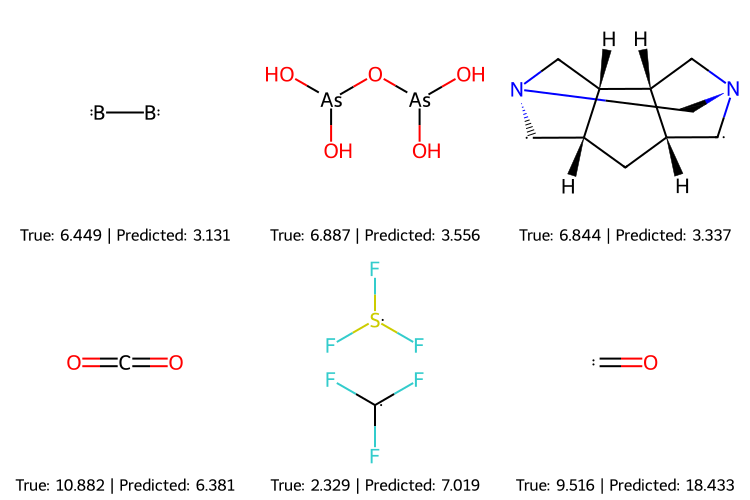

In [ ]:
# find biggest errors
errors = np.abs(val_preds - val_targets.numpy().flatten())
top_k = np.argsort(errors)[-6:] # top 6 largest errors

# get corresponding molecules, gt, pred
Smiles = [valid_smiles[i][0] for i in top_k]
GT = [valid_smiles[i][1] for i in top_k]
Mols = [Chem.MolFromSmiles(s) for s in Smiles]
Pred = [val_preds[i] for i in top_k]
Errs = [errors[i] for i in top_k]

# make labels for the images
labelList = [f"True: {gt:.3f} | Predicted: {pred:.3f}" for gt, pred, err in zip(GT, Pred, Errs)]

# draw  molecules grid using SVG output
img = Draw.MolsToGridImage(Mols, molsPerRow=3, subImgSize=(250, 250), legends=labelList, useSVG=True)
img

# Step 11: Evaluate on test-dev and save the predictions to csv

In [ ]:
# map subset back to original dataset indices
test_indices = split_idx['test-dev']
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_preds = []
all_ids = [] # store original molecule indices

with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader, desc="Predicting")):
        batch = batch.to(device)
        pred = model(batch)
        all_preds.append(pred.cpu().numpy())

# stack predictions
all_preds = np.vstack(all_preds)

# match predictions to original indices
submission_df = pd.DataFrame({'mol_index': test_indices,  # original indices
                              'prediction': all_preds.flatten()  # flatten to 1D
                              })

# sort by original molecule ID 
submission_df = submission_df.sort_values('mol_index').reset_index(drop=True)

# save to CSV
submission_df.to_csv("hybridgnn_testdev_predictions_with_ids.csv", index=False)
print("Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'")

Predicting: 100%|██████████| 2298/2298 [00:22<00:00, 102.89it/s]


Predictions with molecule IDs saved to 'hybridgnn_testdev_predictions_with_ids.csv'


# Conclusions

## Model Performance Summary

All baseline models were initially trained and evaluated on a 5,000 molecule subset of the full dataset. Below is a comparison of results across different featurization strategies and model types:

### 2D Baseline Models

| Model Type    | Featurization      | MAE   | RMSE  | R²    | Notes                                 |
| ------------- | ------------------ | ----- | ----- | ----- | ------------------------------------- |
| MLP (Tuned)   | RDKit Fingerprints | 0.426 | 0.574 | 0.798 | Strong performance across all metrics |
| KRR (Tuned)   | RDKit Fingerprints | 0.454 | 0.593 | 0.784 | Good overall, slightly lower R²       |
| RF (Tuned)    | RDKit Fingerprints | 0.423 | 0.583 | 0.791 | Best MAE, very competitive overall    |
| MLP (Tuned)   | Coulomb Matrix     | 0.636 | 0.819 | 0.588 | Significantly weaker performance      |
| MLP (Untuned) | RDKit Fingerprints | 0.467 | 0.609 | 0.772 | Solid untuned baseline                |
| KRR (Untuned) | RDKit Fingerprints | 0.519 | 0.668 | 0.726 | Notable drop from tuned version       |
| RF (Untuned)  | RDKit Fingerprints | 0.426 | 0.587 | 0.788 | Surprisingly close to tuned RF        |
| MLP (Untuned) | Coulomb Matrix     | 0.663 | 0.847 | 0.559 | Consistently underperforms            |

### Graph Neural Network Models (ChemML)

| Model Type    | Featurization               | MAE   | RMSE  | R²    | Notes                                |
| ------------- | --------------------------- | ----- | ----- | ----- | ------------------------------------ |
| GNN (Tuned)   | `tensorise_molecules` Graph | 0.302 | 0.411 | 0.900 | Best results from ChemML experiments |
| GNN (Untuned) | `tensorise_molecules` Graph | 0.400 | 0.519 | 0.841 | Strong but less optimized            |

### Final Hybrid GNN Model Trained on Full Dataset (OGB-Compatible)

| Model Type           | Featurization                          | MAE   | RMSE  | R²    | Notes                              |
| -------------------- | -------------------------------------- | ----- | ----- | ----- | ---------------------------------- |
| Hybrid GNN (Tuned)   | OGB `smiles2graph` + RDKit descriptors | 0.159 | 0.234 | 0.965 | State-of-the-art level performance |
| Hybrid GNN (Untuned) | OGB `smiles2graph` + RDKit descriptors | 0.223 | 0.308 | 0.939 | Still very strong pre-tuning       |

---

## Model Error Analysis

I performed qualitative evaluation by comparing predicted vs. true HOMO–LUMO gaps for both randomly selected and poorly predicted molecules. The worst performing molecules often showed rare or complex structures likely underrepresented in the training set. This highlights the importance of structural diversity and potentially more expressive 3D information to improve generalization.

## Next Steps: Integrating 3D Molecular Information

To push performance even further and overcome limitations of 2D graphs and hand crafted descriptors, my next step will involve:

* Using **3D molecular geometries** 
* Incorporating **interatomic distances**, angles, and **spatial encoding** (SchNet, DimeNet, or SE(3)-equivariant models)
* Comparing results against the current best MAE (\~0.159)

This direction aligns with trends in molecular property prediction where 3D aware models often outperform purely 2D approaches, especially for quantum properties like HOMO–LUMO gaps.
